In [1]:
from tensorflow.keras.datasets import cifar10,cifar100
import tensorflow.keras.layers as tfl
from tensorflow.keras import Model, Input, utils,regularizers
from matplotlib.pyplot import imshow, show
import numpy as np
from cv2 import imread, imwrite, resize
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2, MobileNet, mobilenet_v3
from tensorflow import concat, reshape, GradientTape
from tensorflow.keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from tensorflow import one_hot
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [2]:
model_backbone = MobileNetV3Small(
    input_shape=(224,224,3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation='softmax',
    include_preprocessing=True
)

4334752/4334752 [==============================] - 1s 0us/step


In [ ]:
model_backbone.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:
for layer in model_backbone.layers:
  print(layer.name)

input_1
rescaling
Conv
Conv/BatchNorm
tf.__operators__.add
re_lu
tf.math.multiply
multiply
expanded_conv/depthwise/pad
expanded_conv/depthwise
expanded_conv/depthwise/BatchNorm
re_lu_1
expanded_conv/squeeze_excite/AvgPool
expanded_conv/squeeze_excite/Conv
expanded_conv/squeeze_excite/Relu
expanded_conv/squeeze_excite/Conv_1
tf.__operators__.add_1
re_lu_2
tf.math.multiply_1
expanded_conv/squeeze_excite/Mul
expanded_conv/project
expanded_conv/project/BatchNorm
expanded_conv_1/expand
expanded_conv_1/expand/BatchNorm
re_lu_3
expanded_conv_1/depthwise/pad
expanded_conv_1/depthwise
expanded_conv_1/depthwise/BatchNorm
re_lu_4
expanded_conv_1/project
expanded_conv_1/project/BatchNorm
expanded_conv_2/expand
expanded_conv_2/expand/BatchNorm
re_lu_5
expanded_conv_2/depthwise
expanded_conv_2/depthwise/BatchNorm
re_lu_6
expanded_conv_2/project
expanded_conv_2/project/BatchNorm
expanded_conv_2/Add
expanded_conv_3/expand
expanded_conv_3/expand/BatchNorm
tf.__operators__.add_2
re_lu_7
tf.math.multiply

In [ ]:
model_backbone.trainable = False

In [ ]:
conv_9_ouput = model_backbone.get_layer(model_backbone.layers[-1].name).output

In [ ]:
conv_9_ouput.shape

TensorShape([None, 7, 7, 576])

In [3]:
class HierarchicalModel(Model):
    def __init__(self, inputs, outputs):
        super().__init__(inputs, outputs)

    # def compile(self, optimizer, lamb, sigma, metrics=None,**kwargs):
    #     super(HierarchicalModel, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
    #     self.lamb = lamb
    #     self.sigma = sigma
    def set_hyper(self, lamb, sigma):
        self.lamb = lamb
        self.sigma = sigma
    def set_hyper(self, lamb, sigma):
        self.lamb = lamb
        self.sigma = sigma
    def train_step(self, data):
        x, y = data
        y_true_category = y['category']
        y_true_grade = y['grade']
        with GradientTape() as tape:
            [y_pred_category, y_pred_grade] = self(x, training=True)
            category_loss = categorical_crossentropy(y_true_category, y_pred_category)
            grade_loss = categorical_crossentropy(y_true_grade, y_pred_grade)

            correct_category = tf.reduce_all(tf.equal(tf.argmax(y_true_category, axis=1), tf.argmax(y_pred_category, axis=1)), axis=-1)
            correct_grade = tf.reduce_all(tf.equal(tf.argmax(y_true_grade, axis=1), tf.argmax(y_pred_grade, axis=1)),axis=-1)
            both_correct = tf.cast(correct_category & correct_grade, tf.float32)
            penalty = 1.0 - both_correct  # 1 if either is wrong, 0 if both are correct

            combined_loss = (1 - self.lamb) * category_loss + self.lamb * grade_loss + self.sigma * penalty * (category_loss*grade_loss)

        # Compute gradients
        gradients = tape.gradient(combined_loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, [y_pred_category, y_pred_grade])

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [4]:
def backbone_model(
    image_shape = (224, 224 , 3),
    category_depth = 9,
    trainable = False):

  backbone = MobileNetV3Small(
    input_shape= image_shape,
    include_top= False,
    weights= 'imagenet',
    input_tensor= None,
    dropout_rate= 0.2,
    include_preprocessing= True)

  backbone.trainable = trainable

  last_layer = backbone.get_layer(backbone.layers[-1].name).output

  conv_output = backbone.get_layer(f'expanded_conv_{str(category_depth)}/Add').output

  return Model(inputs = backbone.input, outputs = [last_layer, conv_output])


In [30]:
def hierarchical_model(
    image_shape = (224, 224 , 3),
    category_depth = 9,
    category_num = 2,
    grade_num = 2,
    L2 = 0):


    backbone = backbone_model(
    image_shape = image_shape,
    category_depth = category_depth,
    trainable = False)

    backbone.trainable = False

    input = Input(shape = image_shape)

    [x, conv_output] = backbone(input, training = False)

    x_category = tfl.Flatten()(conv_output)
    x_category = tfl.Dropout(0.4)(x_category)
    x_category = tfl.Dense(256, activation = 'relu', kernel_regularizer= regularizers.l2(L2))(x_category)
    x_category = tfl.Dropout(0.3)(x_category)
    x_category = tfl.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2))(x_category)
    x_category = tfl.Dropout(0.2)(x_category)
    category_output = tfl.Dense(category_num, activation = 'softmax', name = 'category', kernel_regularizer=regularizers.l2(L2))(x_category)


    x_grade = tfl.Flatten()(x)
    x_grade = tfl.Dropout(0.5)(x_grade)
    x_grade = tfl.Dense((95), activation='relu', kernel_regularizer=regularizers.l2(L2*4.5))(x_grade)
    x_grade = tfl.Dropout(0.35)(x_grade)
    x_grade = tfl.Dense((24), activation = 'relu', kernel_regularizer= regularizers.l2(L2*4.5))(x_grade)
    x_grade = tfl.Dropout(0.25)(x_grade)
    x_grade = concat([x_grade, category_output], -1)
    grade_output = tfl.Dense(grade_num, activation = 'softmax', name = 'grade', kernel_regularizer= regularizers.l2(L2*4.5))(x_grade)

    model = HierarchicalModel(inputs = input, outputs = [category_output, grade_output])

    return model

In [8]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

file_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/hierachical_5_3_224x224_30350.h5'

with h5py.File(file_path, 'r') as hf:
    x_train = hf['images'][()]
    y_category = hf['labels'][()]
    y_grade = hf['qualities'][()]
print(x_train.shape)
print(y_category.shape)
print(y_grade.shape)

print(x_train.shape)
print(y_category.shape)
print(y_grade.shape)
category_num = len(set(y_category))
grade_num = len(set(y_grade))

print(category_num)
print(grade_num)

(30350, 224, 224, 3)
(30350,)
(30350,)
(30350, 224, 224, 3)
(30350,)
(30350,)
6
3


In [9]:
y_category_onehot = np.array(reshape(one_hot(y_category,category_num),(-1,category_num)))
y_grade_onehot = np.array(reshape(one_hot(y_grade,grade_num),(-1,grade_num)))

from sklearn.model_selection import train_test_split
X_train, X_test, y_category_train, y_category_test, y_grade_train, y_grade_test = train_test_split(
    x_train, y_category_onehot, y_grade_onehot, test_size=0.2, random_state=42
)


In [10]:
train_dataset = Dataset.from_tensor_slices((X_train, {'category': y_category_train, 'grade': y_grade_train}))
train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(32)


In [11]:
test_dataset = Dataset.from_tensor_slices((X_test, {'category': y_category_test, 'grade': y_grade_test}))
test_dataset = test_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(32)


In [31]:
model = hierarchical_model(category_num=category_num, grade_num=grade_num, L2=0.3)
model.summary()

Model: "hierarchical_model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        [(None, 7, 7, 576),          939120    ['input_5[0][0]']             
                              (None, 7, 7, 96)]                                                   
                                                                                                  
 flatten_2 (Flatten)         (None, 4704)                 0         ['model_1[0][1]']             
                                                                                                  
 dropout_6 (Dropout)         (None, 4704)                 0         ['flatten_2

In [44]:
lr_schedule = ExponentialDecay(
    4e-5,
    decay_steps=3000,
    decay_rate=0.8,
    staircase=True
)
model.compile(optimizer = Adam(learning_rate=lr_schedule), loss={'category': 'categorical_crossentropy', 'grade': 'categorical_crossentropy'}, metrics = ['accuracy'])
model.set_hyper(lamb=0.5, sigma=12)
history_1 = model.fit(train_dataset, epochs = 10)

Epoch 1/10
759/759 [==============================] - 11s 9ms/step - category_accuracy: 0.9859 - grade_accuracy: 0.9710
Epoch 2/10
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.9895 - grade_accuracy: 0.9734
Epoch 3/10
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.9886 - grade_accuracy: 0.9745
Epoch 4/10
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.9883 - grade_accuracy: 0.9752
Epoch 5/10
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.9883 - grade_accuracy: 0.9752
Epoch 6/10
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.9890 - grade_accuracy: 0.9785
Epoch 7/10
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.9892 - grade_accuracy: 0.9787
Epoch 8/10
759/759 [==============================] - 7s 9ms/step - category_accuracy: 0.9884 - grade_accuracy: 0.9785
Epoch 9/10
759/759 [===========================

In [18]:
import tensorflow as tf
def custom_accuracy(y_true, y_pred):
    # Unpack true labels
    y_true_category = y_true[0]
    y_true_grade = y_true[1]

    # Unpack predicted labels
    y_pred_category = y_pred[0]
    y_pred_grade = y_pred[1]

    # Get the predicted class (highest probability) for both outputs
    y_pred_category = tf.argmax(y_pred_category, axis=-1)
    y_pred_grade = tf.argmax(y_pred_grade, axis=-1)

    # Get the true class for both outputs
    y_true_category = tf.argmax(y_true_category, axis=-1)
    y_true_grade = tf.argmax(y_true_grade, axis=-1)

    # Compare both predictions with true labels
    is_correct_category = tf.equal(y_pred_category, y_true_category)
    is_correct_grade = tf.equal(y_pred_grade, y_true_grade)

    # Only count as correct if both category and grade are correct
    is_correct = tf.logical_and(is_correct_category, is_correct_grade)
    # Convert boolean tensor to float and take the mean to get accuracy
    return tf.reduce_mean(tf.cast(is_correct, tf.float32))

def category_accuracy(y_true, y_pred):
    y_true_category = tf.argmax(y_true, axis=-1)
    y_pred_category = tf.argmax(y_pred, axis=-1)
    is_true = tf.equal(y_true_category, y_pred_category)
    return tf.reduce_mean(tf.cast(is_true, tf.float32))

def grade_accuracy(y_true, y_pred):
    y_true_grade = tf.argmax(y_true, axis=-1)
    y_pred_grade = tf.argmax(y_pred, axis=-1)
    is_true = tf.equal(y_true_grade, y_pred_grade)
    return tf.reduce_mean(tf.cast(is_true, tf.float32))


In [19]:
all_X = []
all_y_category = []
all_y_grade = []
count = 0
# Iterate over the dataset to collect all data and labels
for batch in test_dataset:
    X, y = batch  # Unpack the batch into X (inputs) and y (labels)

    # Collect batch of inputs
    all_X.append(X.numpy())  # Assuming X is a TensorFlow tensor, convert to NumPy if needed

    # Collect batch of labels
    all_y_category.append(y['category'].numpy())  # Assuming y['category'] is a TensorFlow tensor
    all_y_grade.append(y['grade'].numpy())  # Assuming y['grade'] is a TensorFlow tensor
    count += 1

print(count)
# Concatenate all batches into single arrays or lists
all_X = tf.concat(all_X, axis=0)  # Concatenate along batch dimension if X is a tensor
all_y_category = tf.concat(all_y_category, axis=0)  # Concatenate along batch dimension if y['category'] is a tensor
all_y_grade = tf.concat(all_y_grade, axis=0)  # Concatenate along batch dimension if y['grade'] is a tensor
print(all_X.shape)
print(all_y_category.shape)
print(all_y_grade.shape)

190
(6070, 224, 224, 3)
(6070, 6)
(6070, 3)


In [45]:
model.evaluate(test_dataset)
outputs = model.predict(all_X)
[pred_category, pred_grade] = outputs
print(pred_category.shape)
print(pred_grade.shape)

print('Overall_accuracy :', custom_accuracy([all_y_category,all_y_grade], [pred_category, pred_grade]).numpy())
print('Category_accuracy :',category_accuracy(all_y_category, pred_category).numpy())
print('Grade_accuracy :',category_accuracy(all_y_grade, pred_grade).numpy())

190/190 [==============================] - 2s 6ms/step
(6070, 6)
(6070, 3)
Overall_accuracy : 0.8904448
Category_accuracy : 0.9714992
Grade_accuracy : 0.91449755


In [ ]:
def flat_model(
    image_shape = (224, 224 , 3),
    num_class = 4,
    L2 = 0
):
    backbone = backbone_model(
    image_shape = image_shape,
    trainable = False)

    backbone.trainable = False

    input = Input(shape = image_shape)

    [last_layer, conv_output] = backbone(input, training = False)

    X = tfl.Flatten()(last_layer)
    X = tfl.Dense(200, activation = 'relu', kernel_regularizer= regularizers.l2(L2))(X)
    X = tfl.Dropout(0.2)(X)
    X = tfl.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2))(X)
    X = tfl.Dropout(0.2)(X)
    outputs = tfl.Dense(num_class, activation = 'softmax', name = 'category')(X)

    model = Model(inputs = input, outputs = outputs)

    return model

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

file_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/flat_15_224x224_6976.h5'

with h5py.File(file_path, 'r') as hf:
    X = hf['images'][()]
    Labels = hf['class'][()]
print(X.shape)
print(Labels.shape)
Labels = np.array(reshape(one_hot(Labels,15),(-1,15)))
print(Labels.shape)

(6976, 224, 224, 3)
(6976,)
(6976, 15)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Labels, test_size=0.2, random_state=42
)


train_set = Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(buffer_size=2000, reshuffle_each_iteration=True)
train_set = train_set.batch(32)
test_set = Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.shuffle(buffer_size=2000, reshuffle_each_iteration=True)
test_set = test_set.batch(32)

In [ ]:
cardinary_model = flat_model(num_class = 15)
cardinary_model.compile(optimizer = Adam(learning_rate=5e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])
cardinary_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_2 (Functional)        [(None, 7, 7, 576),       939120    
                              (None, 7, 7, 96)]                  
                                                                 
 flatten_3 (Flatten)         (None, 28224)             0         
                                                                 
 dense_4 (Dense)             (None, 200)               5645000   
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               25728     
                                                           

In [ ]:
cardinary_model.fit(train_set, epochs = 20)

Epoch 1/20
175/175 [==============================] - 9s 28ms/step - loss: 2.1471 - accuracy: 0.3217
Epoch 2/20
175/175 [==============================] - 3s 19ms/step - loss: 0.7925 - accuracy: 0.7876
Epoch 3/20
175/175 [==============================] - 4s 23ms/step - loss: 0.2116 - accuracy: 0.9659
Epoch 4/20
175/175 [==============================] - 4s 20ms/step - loss: 0.0582 - accuracy: 0.9982
Epoch 5/20
175/175 [==============================] - 3s 20ms/step - loss: 0.0247 - accuracy: 1.0000
Epoch 6/20
175/175 [==============================] - 4s 22ms/step - loss: 0.0143 - accuracy: 1.0000
Epoch 7/20
175/175 [==============================] - 4s 21ms/step - loss: 0.0096 - accuracy: 1.0000
Epoch 8/20
175/175 [==============================] - 4s 20ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 9/20
175/175 [==============================] - 3s 19ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 10/20
175/175 [==============================] - 4s 22ms/step - loss: 0.0040 - accura

In [ ]:
cardinary_model.evaluate(test_set)

44/44 [==============================] - 2s 18ms/step - loss: 0.6315 - accuracy: 0.8388


[0.631544828414917, 0.8388252258300781]

In [ ]:
def category_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis = 1)//3
    y_pred = tf.argmax(y_pred, axis = 1)//3
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

def grade_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis = 1).numpy()%3
    y_pred = tf.argmax(y_pred, axis = 1).numpy()%3
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

In [ ]:
y_pred = cardinary_model.predict(X_test)
y_test
print(category_accuracy(y_test, y_pred))
print(grade_accuracy(y_test, y_pred))

44/44 [==============================] - 1s 18ms/step
tf.Tensor(0.9111748, shape=(), dtype=float32)
tf.Tensor(0.89111745, shape=(), dtype=float32)


In [ ]:
def accuracy(y_true, y_pred, threshold = 0.5):
  y_pred = np.where(y_pred > threshold, 1, 0)
  return np.sum(y_true == y_pred) / len(y_true)

In [ ]:
def custom_accuracy(y_true, y_pred):
    # Unpack true labels
    y_true_category = y_true[0]
    y_true_grade = y_true[1]

    # Unpack predicted labels
    y_pred_category = y_pred[0]
    y_pred_grade = y_pred[1]

    # Get the predicted class (highest probability) for both outputs
    y_pred_category = tf.argmax(y_pred_category, axis=-1)
    y_pred_grade = tf.argmax(y_pred_grade, axis=-1)

    # Get the true class for both outputs
    y_true_category = tf.argmax(y_true_category, axis=-1)
    y_true_grade = tf.argmax(y_true_grade, axis=-1)

    # Compare both predictions with true labels
    is_correct_category = tf.equal(y_pred_category, y_true_category)
    is_correct_grade = tf.equal(y_pred_grade, y_true_grade)

    # Only count as correct if both category and grade are correct
    is_correct = tf.logical_and(is_correct_category, is_correct_grade)
    for i in range(len(is_correct)):
      print(is_correct[i].numpy(),'Category:', is_correct_category[i].numpy(),"Grade", is_correct_grade[i].numpy())
    # Convert boolean tensor to float and take the mean to get accuracy
    return tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [ ]:
print(y_category[0], y_grade[0])
# imshow(x_train[0])


tf.Tensor([1. 0.], shape=(2,), dtype=float32) tf.Tensor([1. 0.], shape=(2,), dtype=float32)


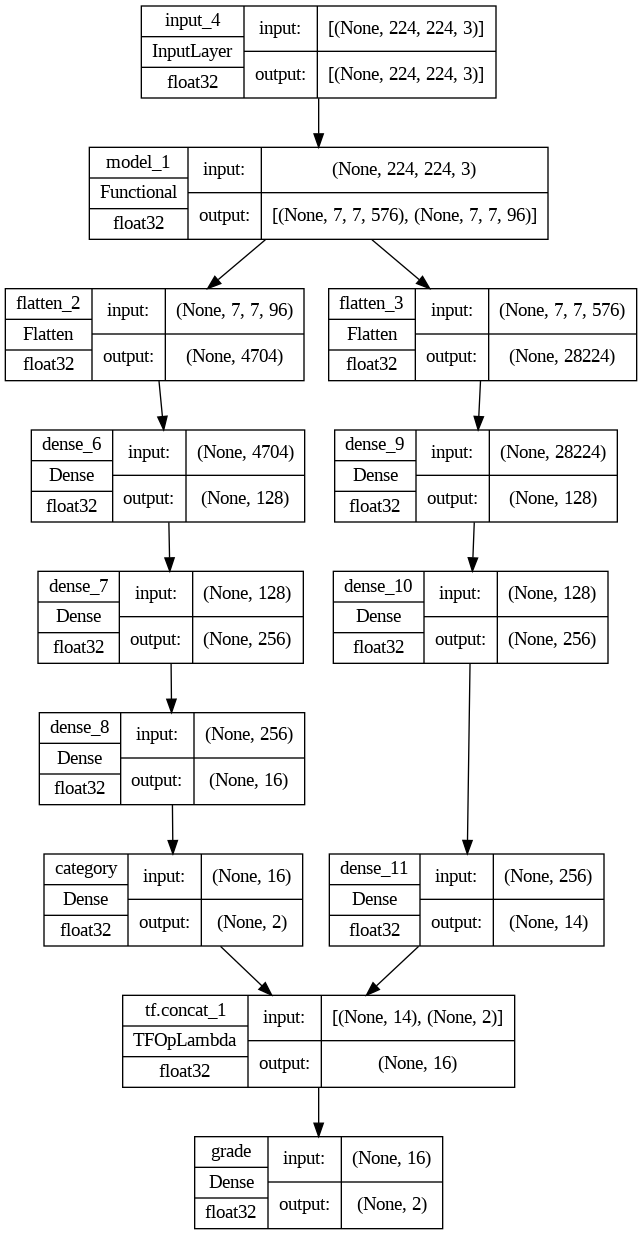

In [ ]:
utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
# import tensorflow as tf
# @tf.function
def combined_loss(y_true, y_pred, lamb=0.5):
    print(y_true.shape)
    print(y_pred.shape)
    y_true_category, y_true_grade = y_true[0, :], y_true[1, :]
    y_pred_category, y_pred_grade = y_pred[0, :], y_pred[1, :]

    category_loss = categorical_crossentropy(y_true_category, y_pred_category)
    grade_loss = categorical_crossentropy(y_true_grade, y_pred_grade)

    return (1 - lamb) * category_loss + lamb * grade_loss + 5* category_loss * grade_loss